# Passos para realizar uma análise exploratória de dados

- Limpeza de outliers
- Análise da utilidade de colunas para o modelo final e preenchimento de colunas com nulos.

## Vamos tentar nos livrar dos pontos fora da curva

- O que são esses pontos fora da curva?

São dados que não fazem sentido, devido ao seu contexto. Por exemplo, um time com 30 gols. É praticamente impossível de acontecer, casos extremos -apesar de poucos- podem causar grande impacto em nosso modelo. Eles tornam a análise enviesada, por isso devemos tratá-los.

### Como limpar os pontos fora da curva?

Podemos fazer uma análise artesanal de cada coluna, seguindo o senso do contexto, que nesse caso é o futebol. Além disso, também podemos usar alguns métodos como o IQR.

- Análise artesanal (como deve se comportar as colunas):
    - chutes a gol < 10
    - faltas < 40
    - substituições < 6
    - posse de bola 1 + posse de bola 2 igual a 100
    - posse de bola 1/2 < 99% e posse de bola 1/2 > 1%
    - cartões amarelos < 8
    - cartões vermelho < 3
- Método IQR

O IQR é baseado em quartis, que dividem um conjunto de dados ordenados em quatro partes iguais:

Q1 (primeiro quartil): 25% dos dados estão abaixo desse valor.

Q3 (terceiro quartil): 75% dos dados estão abaixo desse valor.

IQR (Intervalo Interquartil): IQR=Q3−Q1IQR=Q3−Q1

Esse intervalo representa o “miolo” dos dados, ou seja, onde estão os valores mais comuns (entre 25% e 75%).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega o CSV
df_original = pd.read_csv('entrada.csv')
df = df_original.copy()

# Cabeçalho da tabela
print(f"{'Coluna':<25} {'Qtd Outliers':<15} {'Média Outliers':<20} {'% Removido':<12}")
print('-' * 72)

# Define colunas com tratamento especial
colunas_gols = ['Gols 1', 'Gols 2']
colunas_faltas = ['Faltas 1', 'Faltas 2']
colunas_subs = ['Substituições 1', 'Substituições 2']
colunas_posse = ['Posse 1(%)', 'Posse 2(%)']
colunas_cartoes_amarelos = ['Cartões amarelos 1', 'Cartões amarelos 2']
colunas_cartoes_vermelhos = ['Cartões vermelhos 1', 'Cartões vermelhos 2']

# Função padrão com IQR ajustado
def identificar_outliers_iqr(coluna):
    Q1 = coluna.quantile(0.25)
    Q3 = coluna.quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 2.7 * IQR    # Ajustado para apenas detectar outliers extremos
    limite_superior = Q3 + 2.7 * IQR    # Ajustado para apenas detectar outliers extremos
    return coluna[(coluna < limite_inferior) | (coluna > limite_superior)]

# Tratamento especial

df = df[(df['Posse 1(%)'] + df['Posse 2(%)']).round(1) == 100] # Remove linhas onde a soma de posse não é ~100%


def identificar_outliers_personalizado(coluna, nome):
    if nome in colunas_gols:
        return coluna[coluna >= 10]
    elif nome in colunas_faltas:
        return coluna[coluna >= 40]
    elif nome in colunas_subs:
        return coluna[coluna >= 6]
    elif nome in colunas_cartoes_amarelos:
        return coluna[coluna > 8]
    elif nome in colunas_cartoes_vermelhos:
        return coluna[coluna > 3]
    else:
        return identificar_outliers_iqr(coluna)

# Itera por cada coluna numérica
for coluna in df.select_dtypes(include=['int64', 'float64']).columns:
    serie = df[coluna]
    outliers = identificar_outliers_personalizado(serie, coluna)
    qtd_outliers = len(outliers)
    media_outliers = outliers.mean() if not outliers.empty else 0
    perc_outliers = (qtd_outliers / len(df_original)) * 100

    # Remove os outliers
    df = df[~df[coluna].isin(outliers)]

    # Imprime linha da tabela
    print(f"{coluna:<25} {qtd_outliers:<15} {media_outliers:<20.2f} {perc_outliers:<.2f}%")

# Salva o CSV limpo
df.to_csv('saida_sem_outliers.csv', index=False)
print("\nArquivo limpo salvo como 'saida_sem_outliers.csv'")

Coluna                    Qtd Outliers    Média Outliers       % Removido  
------------------------------------------------------------------------
Chutes a gol 1            79              17.16                0.29%
Chutes a gol 2            42              16.90                0.15%
Impedimentos 1            118             9.86                 0.43%
Impedimentos 2            76              9.71                 0.27%
Escanteios 1              24              18.71                0.09%
Escanteios 2              44              15.98                0.16%
Chutes fora 1             46              20.43                0.17%
Chutes fora 2             27              46.15                0.10%
Faltas 1                  1               46.00                0.00%
Faltas 2                  2               105.00               0.01%
Cartões amarelos 1        2               10.00                0.01%
Cartões amarelos 2        6               9.00                 0.02%
Cartões vermelhos 1    

### O que concluímos?

Podemos ver que algumas bizarrices foram eliminadas, como por exemplo 2 linhas em que a média das faltas foi 105, não é realista. Vale ressaltar que perdemos pouquíssima informação, não passando de 0.5% os índices de remoção de linhas. Com esses ajustes, podemos prosseguir para a análise individual das colunas.

## Vamos analisar as colunas individualmente

Primeiramente, devemos considerar o objetivo da análise, que no caso é criar um modelo de previsão de resultado de jogo de futebol. Para isso, precisamos verificar o quão relevante as colunas que vamos investigar são para o número de gols. Escolhemos 'gols' como alvo, pois a diferença de número de gols dos times que indica vitória, derrota e empate.


Nesse documento, vamos focar na análise das seguintes colunas:
- Tiros de meta
- Substituições
- Contra-ataques

### Tiros de meta

Primeiramente, vamos dar uma olhada na composição dos dados não nulos que temos disponíveis. Da forma em que está, temos 12910 dados nulos (52.68%) e 11595 dados não nulos (47.32%). Dada essa grande ausência de dados, precisamos usar métodos que aproveitem da correlação com outras colunas para preenchermos os dados faltantes com uso dos vizinhos.

In [ ]:
df = pd.read_csv("saida_sem_outliers.csv")

for col in ['Tiro de meta 1', 'Tiro de meta 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Tiro de meta 1
nulos     : 12910 (52.68%)
não nulos : 11595 (47.32%)
----------------------------------------
Tiro de meta 2
nulos     : 12910 (52.68%)
não nulos : 11595 (47.32%)
----------------------------------------


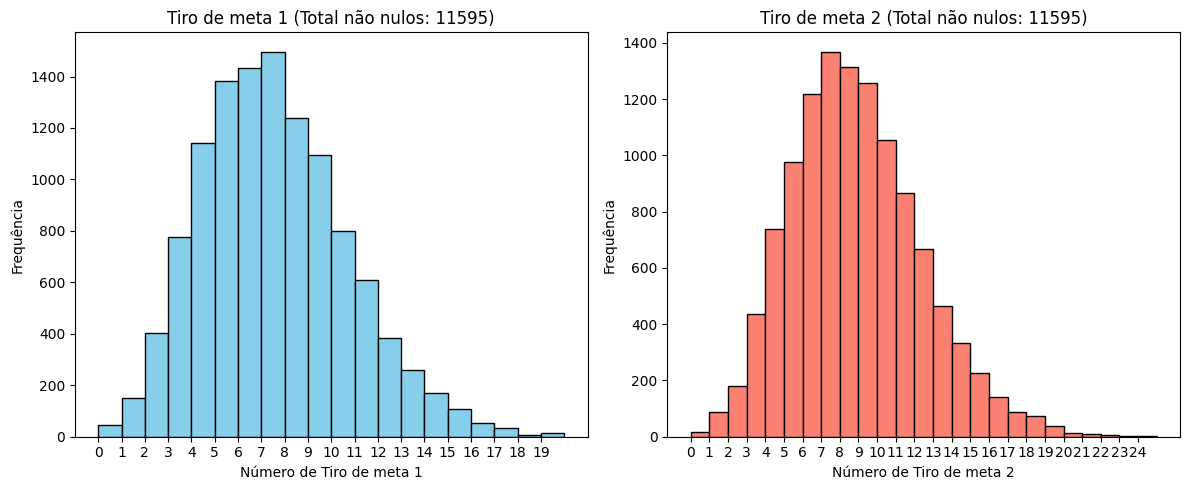

Tiro de meta 1 - média: 7.078137128072445
Tiro de meta 2 - média: 8.3742992669254
Tiro de meta 1 - mediana: 7.0
Tiro de meta 2 - mediana: 8.0


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers.csv', 'Tiro de meta 1', 'Tiro de meta 2')

Para resolver esse problema, vamos optar pelo método KNN (K-Nearest Neighbors). Esse algorítmo procura os vizinhos próximos e usamos a sua distância para prever um valor que seria válido de acordo com as semelhanças dos vizinhos. Se fossemos levar para um contexto mais simples, esse algorítmo copia o trabalho das colunas vizinhas semelhantes e tentar gerar sua própria versão com oque analisou. Para escolhermos quais colunas nos interessam para usar no KNN devemos olhar para o gráfico abaixo:

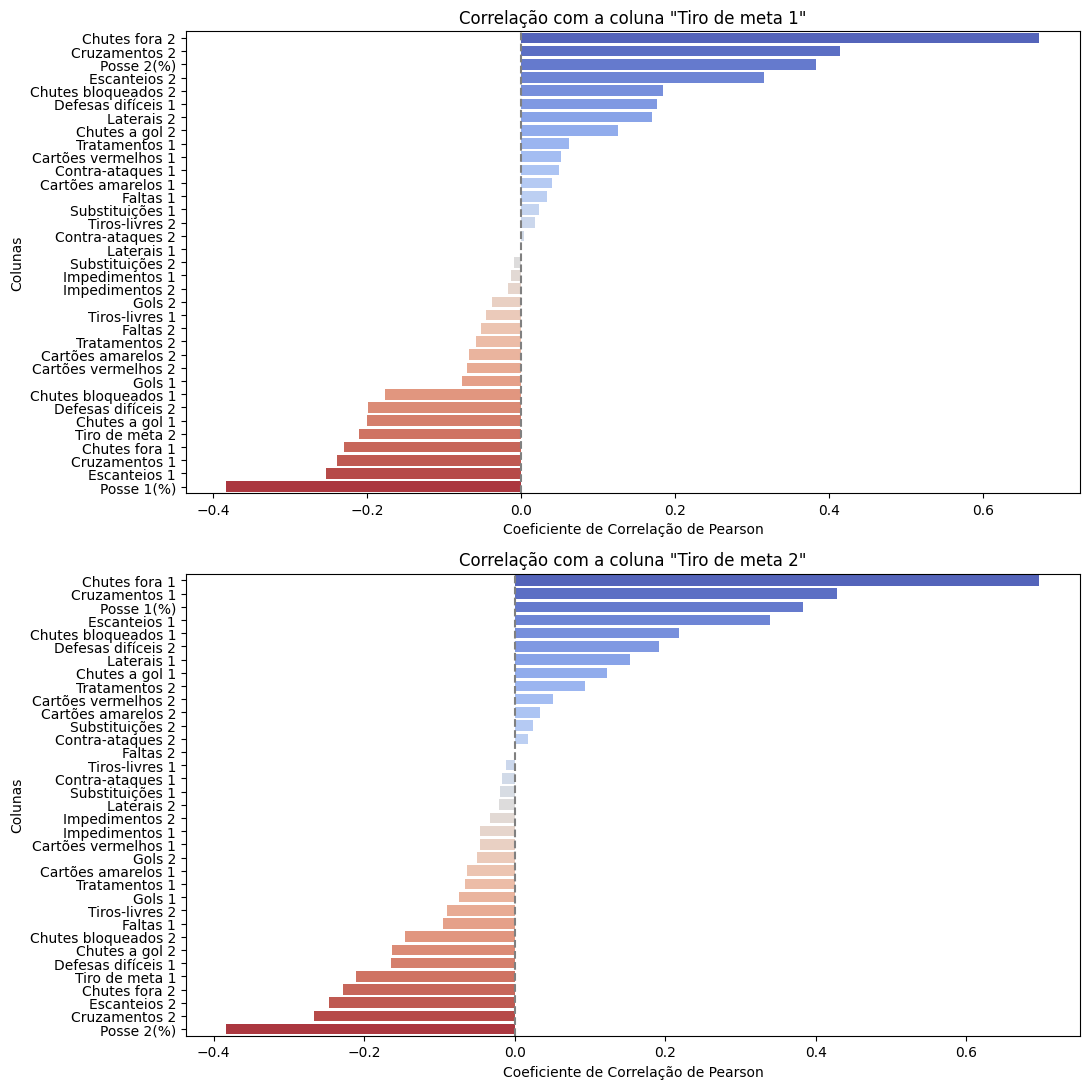

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def grafico_correlacoes(csv_path, colunas_alvo):
    # Lê o CSV
    df = pd.read_csv(csv_path)
    
    # Garante que só colunas numéricas sejam usadas na correlação
    df_numerico = df.select_dtypes(include='number')
    
    # Verifica se todas as colunas alvo existem no dataset
    for coluna in colunas_alvo:
        if coluna not in df_numerico.columns:
            raise ValueError(f"A coluna '{coluna}' não é numérica ou não está no dataset.")
    
    # Número de subgráficos (linhas)
    num_colunas = len(colunas_alvo)

    plt.figure(figsize=(11, 11))
    
    for i, coluna_alvo in enumerate(colunas_alvo, start=1):
        # Calcula a correlação da coluna alvo com todas as outras
        correlacoes = df_numerico.corr()[coluna_alvo].drop(labels=[coluna_alvo])

        # Ordena por valor da correlação
        correlacoes_ordenadas = correlacoes.sort_values(ascending=False)

        # Cria subgráfico
        plt.subplot(num_colunas, 1, i)  # Divide o espaço em linhas
        sns.barplot(x=correlacoes_ordenadas.values, y=correlacoes_ordenadas.index, palette='coolwarm', orient='h')
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.title(f'Correlação com a coluna "{coluna_alvo}"')
        plt.xlabel('Coeficiente de Correlação de Pearson')
        plt.ylabel('Colunas')
    
    plt.tight_layout()
    plt.show()

grafico_correlacoes('saida_sem_outliers.csv', ['Tiro de meta 1', 'Tiro de meta 2'])

As colunas candidatas para nosso método KNN são as de maior correlação, elas são:

- Chutes fora ✅
- Cruzamento ❌
- Posse ✅
- Escanteios ✅

Agora vamos verificar se essas candidatas são válidas ou não.

In [ ]:
df = pd.read_csv("saida_sem_outliers.csv")

for col in ['Chutes fora 1', 'Chutes fora 2', 'Cruzamentos 1', 'Cruzamentos 2', 'Posse 1(%)', 'Posse 2(%)', 'Escanteios 1', 'Escanteios 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Chutes fora 1
nulos     : 6 (0.02%)
não nulos : 24499 (99.98%)
----------------------------------------
Chutes fora 2
nulos     : 6 (0.02%)
não nulos : 24499 (99.98%)
----------------------------------------
Cruzamentos 1
nulos     : 15979 (65.21%)
não nulos : 8526 (34.79%)
----------------------------------------
Cruzamentos 2
nulos     : 15979 (65.21%)
não nulos : 8526 (34.79%)
----------------------------------------
Posse 1(%)
nulos     : 0 (0.00%)
não nulos : 24505 (100.00%)
----------------------------------------
Posse 2(%)
nulos     : 0 (0.00%)
não nulos : 24505 (100.00%)
----------------------------------------
Escanteios 1
nulos     : 9 (0.04%)
não nulos : 24496 (99.96%)
----------------------------------------
Escanteios 2
nulos     : 9 (0.04%)
não nulos : 24496 (99.96%)
----------------------------------------


✅ Começamos por 'Chutes fora', o tiro de meta geralmente advém de um chute fora feito pelo time adversário. Isso ficou bem claro no gráfico, praticamente 0.7 de coeficiente de correlação. E além disso, a quantidade de dados não nulos de 'Chutes fora' é infima, tornando-se assim perfeita candidata.

❌ 'Cruzamentos', por outro lado, apenas analisando a quantidade de dados nulos, eles são maioria (65.21%), tornando praticamente inútil o seu uso.

✅ 'Posse' é forte candidata pelo coeficiente de correlação alto (de quase 0.4) e além disso, 100% dos seus dados são não nulos!

✅ 'Escanteios' tem poucos dados nulos, que é um primeiro bom sinal. Além disso, possui uma correlação considerável de entre 0.2 e 0.3 de coeficiente de correlação. Tornando-se assim, uma boa coluna candidata também.

In [ ]:
def preencher_com_knn(caminho_entrada, caminho_saida, coluna_alvo, colunas_auxiliares, n_vizinhos=3):
    # Carrega os dados
    df = pd.read_csv(caminho_entrada)

    # Conta nulos antes
    nulos_antes = df[coluna_alvo].isnull().sum()

    # Remove linhas com nulos nas colunas auxiliares
    df_aux = df[colunas_auxiliares + [coluna_alvo]].dropna(subset=colunas_auxiliares)

    # Divide entre linhas com e sem alvo
    df_treino = df_aux[df_aux[coluna_alvo].notnull()]
    df_predicao = df_aux[df_aux[coluna_alvo].isnull()]

    if df_predicao.empty:
        print("[INFO] Nenhum valor nulo para preencher na coluna alvo.")
        df.to_csv(caminho_saida, index=False)
        return

    # Prepara treino
    X_train = df_treino[colunas_auxiliares]
    y_train = df_treino[coluna_alvo]

    # Prepara predição
    X_pred = df_predicao[colunas_auxiliares]

    # Modelo KNN
    model = KNeighborsRegressor(n_neighbors=n_vizinhos)
    model.fit(X_train, y_train)

    # Previsões
    y_pred = model.predict(X_pred)

    # Preenche os nulos no dataframe original
    df.loc[df[coluna_alvo].isnull() & df[colunas_auxiliares].notnull().all(axis=1), coluna_alvo] = y_pred

    # Pós-preenchimento
    nulos_depois = df[coluna_alvo].isnull().sum()
    nulos_preenchidos = nulos_antes - nulos_depois
    media_preenchida = y_pred.mean()

    # Salva resultado
    df.to_csv(caminho_saida, index=False)

    # Relatório
    print(f"[RELATÓRIO - {coluna_alvo}]")
    print(f"Total de nulos antes:    {nulos_antes}")
    print(f"Nulos preenchidos:       {nulos_preenchidos}")
    print(f"Nulos restantes:         {nulos_depois}")
    print(f"Média dos valores previstos: {media_preenchida:.2f}\n")

preencher_com_knn('saida_sem_outliers.csv', 'saida_sem_outliers_preenchido.csv', 'Tiro de meta 1', ['Chutes fora 2', 'Posse 2(%)', 'Escanteios 2'])
preencher_com_knn('saida_sem_outliers_preenchido.csv', 'saida_sem_outliers_preenchido.csv', 'Tiro de meta 2', ['Chutes fora 1', 'Posse 1(%)', 'Escanteios 1'])

[RELATÓRIO - Tiro de meta 1]
Total de nulos antes:    12910
Nulos preenchidos:       12900
Nulos restantes:         10
Média dos valores previstos: 7.88

[RELATÓRIO - Tiro de meta 2]
Total de nulos antes:    12910
Nulos preenchidos:       12900
Nulos restantes:         10
Média dos valores previstos: 9.31



Agora nos resta plotar o novo resultado que obtivemos!

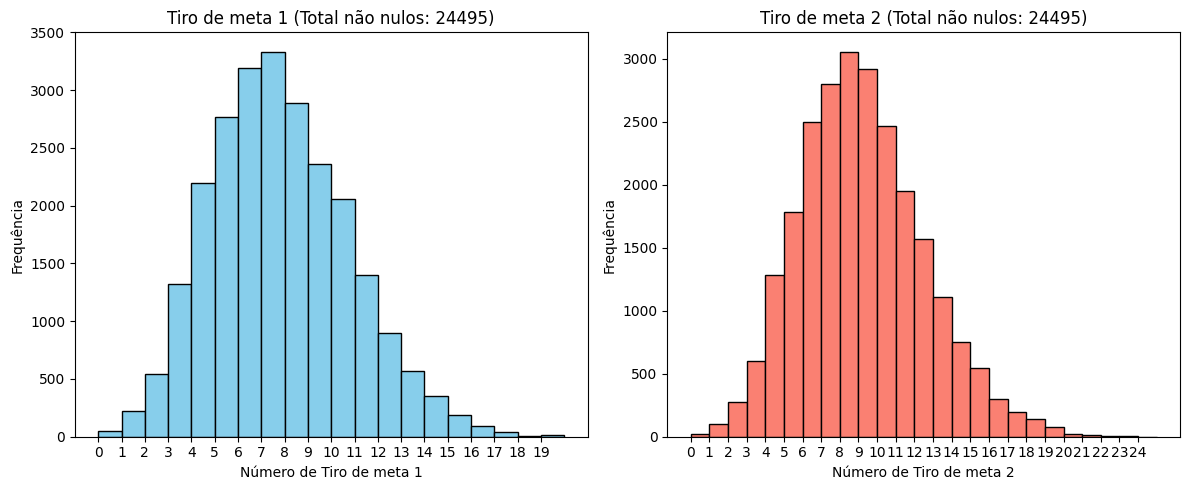

Tiro de meta 1 - média: 7.502524324692113
Tiro de meta 2 - média: 8.868136354358034
Tiro de meta 1 - mediana: 7.0
Tiro de meta 2 - mediana: 8.666666666666666


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers_preenchido.csv', 'Tiro de meta 1', 'Tiro de meta 2')

### Substituições

Para começar, vamos verificar quantos dados possuímos: 15480 nulos (63.17%) e 9025 não nulos (36.83%). Vamos verificar se a coluna é de fato interessante para nosso modelo. Vamos verificar a correlação atual de 'Substituições' com 'gols': a maior correlação é de 0.03. A correlação entre 'Gols' e 'Substituições' é tão baixa que podemos ignorar essa coluna, pois as mudanças nela fazem quase nenhuma diferença nos resultados de gols. Vejamos também o histograma de 'Substituições'.

In [ ]:
df = pd.read_csv("saida_sem_outliers_preenchido.csv")

for col in ['Substituições 1', 'Substituições 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Substituições 1
nulos     : 15480 (63.17%)
não nulos : 9025 (36.83%)
----------------------------------------
Substituições 2
nulos     : 15480 (63.17%)
não nulos : 9025 (36.83%)
----------------------------------------


In [ ]:
df = pd.read_csv("saida_sem_outliers_preenchido.csv")
for g in ['Gols 1', 'Gols 2']:
    for s in ['Substituições 1', 'Substituições 2']:
        print(f"Correlação entre {g} e {s}: {df[g].corr(df[s]):.3f}")

Correlação entre Gols 1 e Substituições 1: 0.020
Correlação entre Gols 1 e Substituições 2: 0.001
Correlação entre Gols 2 e Substituições 1: 0.013
Correlação entre Gols 2 e Substituições 2: 0.030


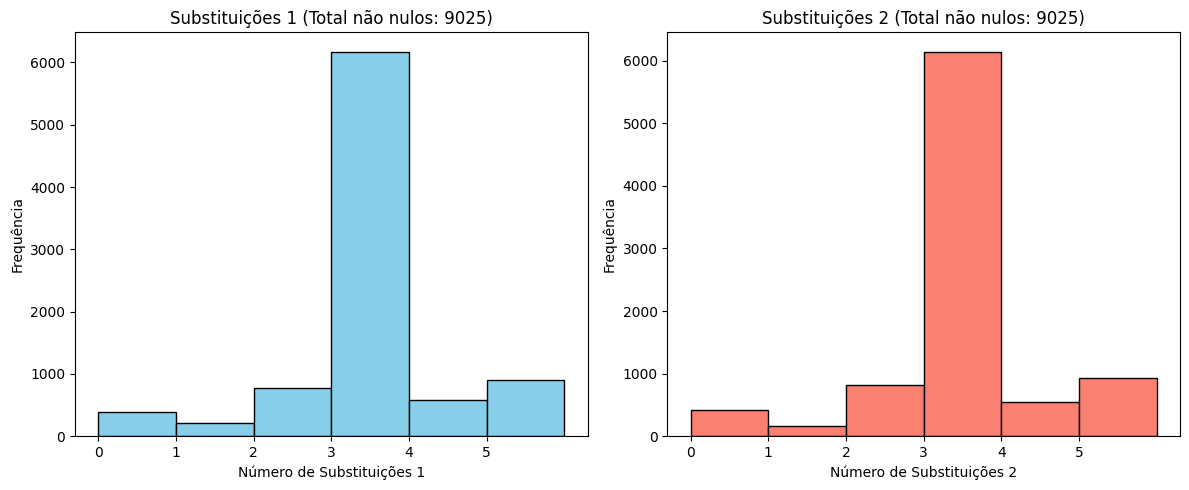

Tiro de meta 1 - média: 2.999113573407202
Tiro de meta 2 - média: 3.0001108033240995
Tiro de meta 1 - mediana: 3.0
Tiro de meta 2 - mediana: 3.0


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers.csv', 'Substituições 1', 'Substituições 2')

Podemos perceber que há uma grande concentração em '3 substituições' isso provavelmente se deve a uma regra que limitava a 3 substituições por jogo. Apesar dessa regra ter mudado em 2022 para 5 substituições máximas. A grande concentração de substituições em 3, sem alterar os resultados, comprova que a coluna está pouco relacionada ao número de gols. Por isso, vamos ignorar essa coluna, então partiremos para a próxima.

### Contra-ataques

Como fizemos com as outras colunas, vejamos a quantidade de dados que temos disponível: 18604 nulos (75.92%) e 5901 (24.08%), percebemos que 3/4 dos dados estão faltando. Agora vamos verificar as correlações em relação a 'gols': existe uma relação na ordem de 0.15 a 0.2 entre as colunas, apesar de não ser uma correlação enorme, não devemos desconsiderá-la. Podemos analisar que contra-ataques tem uma relação positiva com número de gols, e isso faz sentido na lógica do fotebol. 

In [ ]:
df = pd.read_csv("saida_sem_outliers_preenchido.csv")

for col in ['Contra-ataques 1', 'Contra-ataques 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Contra-ataques 1
nulos     : 18604 (75.92%)
não nulos : 5901 (24.08%)
----------------------------------------
Contra-ataques 2
nulos     : 18604 (75.92%)
não nulos : 5901 (24.08%)
----------------------------------------


In [ ]:
df = pd.read_csv("saida_sem_outliers_preenchido.csv")
for g in ['Gols 1', 'Gols 2']:
    for s in ['Contra-ataques 1', 'Contra-ataques 2']:
        print(f"Correlação entre {g} e {s}: {df[g].corr(df[s]):.3f}")

Correlação entre Gols 1 e Contra-ataques 1: 0.158
Correlação entre Gols 1 e Contra-ataques 2: -0.180
Correlação entre Gols 2 e Contra-ataques 1: -0.145
Correlação entre Gols 2 e Contra-ataques 2: 0.206


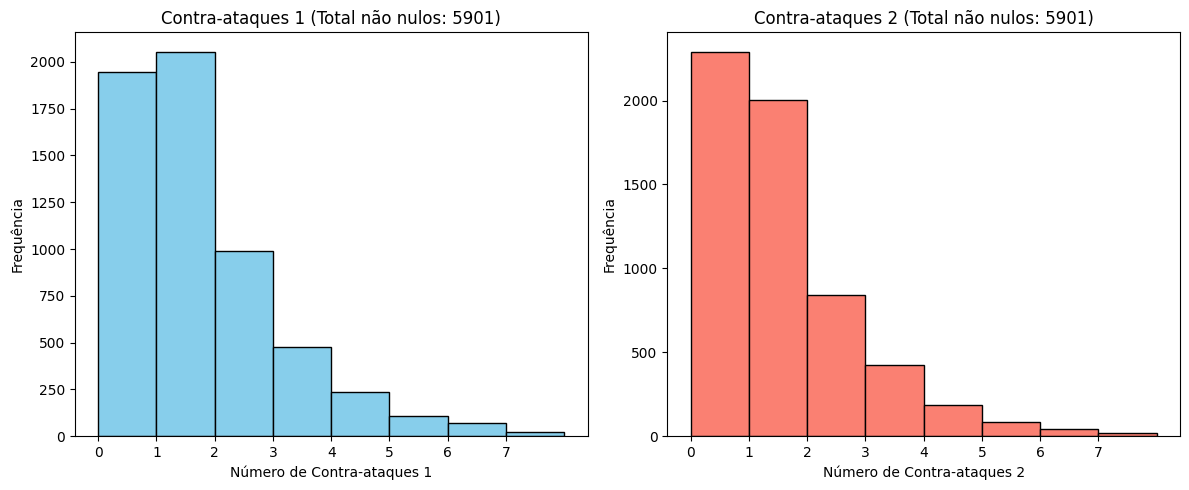

Tiro de meta 1 - média: 1.2758854431452296
Tiro de meta 2 - média: 1.1093035078800204
Tiro de meta 1 - mediana: 1.0
Tiro de meta 2 - mediana: 1.0


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers.csv', 'Contra-ataques 1', 'Contra-ataques 2')

Podemos perceber que há uma concentração do número de contra-ataques em valores baixos.

Vamos analisar as correlações abaixo. Cruzamentos do time adversário está ligado diretamente a contra-ataques, pois quando o time adversário tenta fazer um cruzamento, espaço para um contra-ataque é aberto. Outra correlação lógica seria quanto mais contra-ataques, mais chances de fazer gol, ou seja, gols aumentar. Chutes bloqueados do time adversário aumentarem também seriam uma boa suposição, pois nem todo contra-ataque é bem sucedido, levando a aumentar essa coluna. Vejamos:

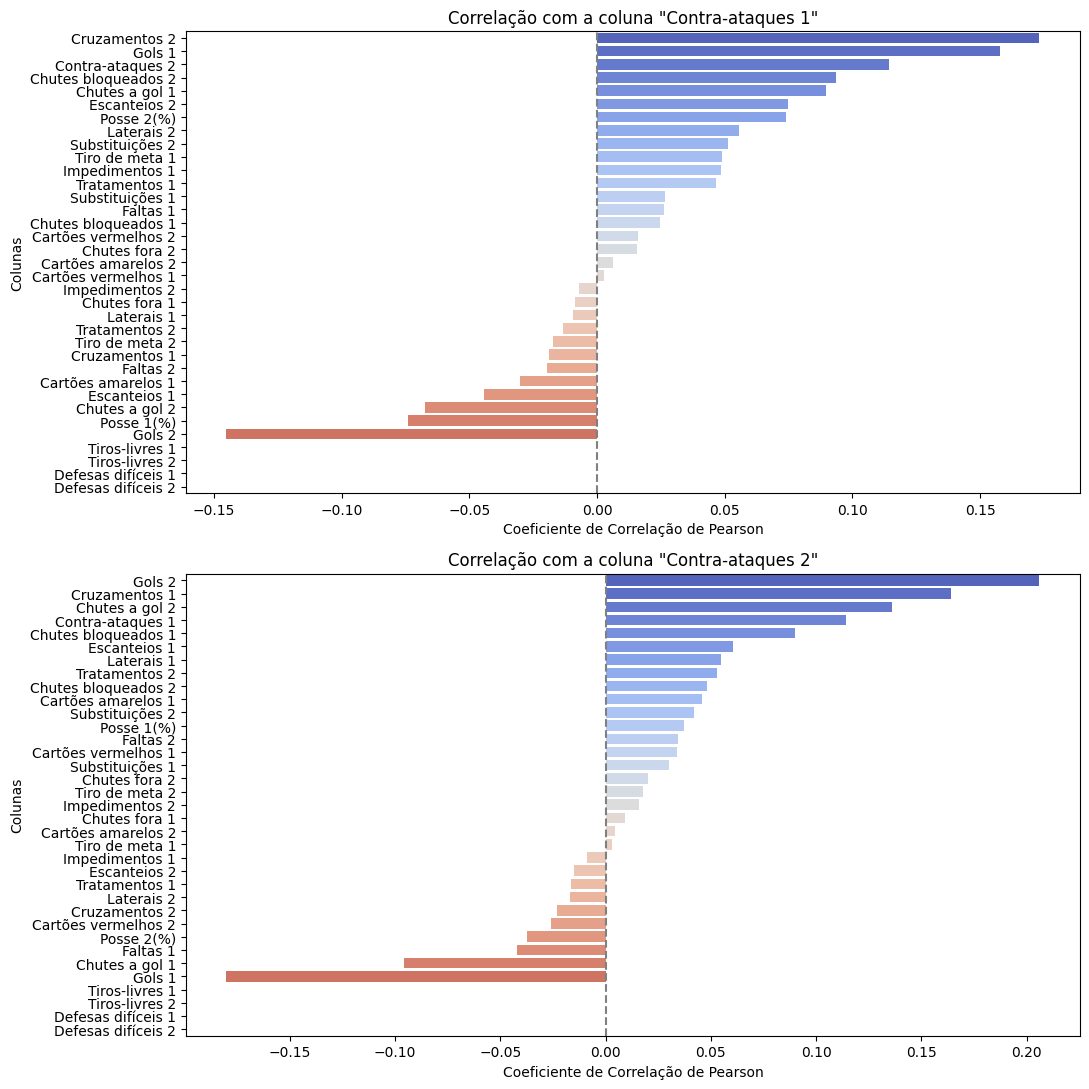

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def grafico_correlacoes(csv_path, colunas_alvo):
    # Lê o CSV
    df = pd.read_csv(csv_path)
    
    # Garante que só colunas numéricas sejam usadas na correlação
    df_numerico = df.select_dtypes(include='number')
    
    # Verifica se todas as colunas alvo existem no dataset
    for coluna in colunas_alvo:
        if coluna not in df_numerico.columns:
            raise ValueError(f"A coluna '{coluna}' não é numérica ou não está no dataset.")
    
    # Número de subgráficos (linhas)
    num_colunas = len(colunas_alvo)

    plt.figure(figsize=(11, 11))
    
    for i, coluna_alvo in enumerate(colunas_alvo, start=1):
        # Calcula a correlação da coluna alvo com todas as outras
        correlacoes = df_numerico.corr()[coluna_alvo].drop(labels=[coluna_alvo])

        # Ordena por valor da correlação
        correlacoes_ordenadas = correlacoes.sort_values(ascending=False)

        # Cria subgráfico
        plt.subplot(num_colunas, 1, i)  # Divide o espaço em linhas
        sns.barplot(x=correlacoes_ordenadas.values, y=correlacoes_ordenadas.index, palette='coolwarm', orient='h')
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.title(f'Correlação com a coluna "{coluna_alvo}"')
        plt.xlabel('Coeficiente de Correlação de Pearson')
        plt.ylabel('Colunas')
    
    plt.tight_layout()
    plt.show()

grafico_correlacoes('saida_sem_outliers.csv', ['Contra-ataques 1', 'Contra-ataques 2'])

Acertamos em cheio. As correlações estão condizentes com a realidade, por tanto, podemos prosseguir para a formulação de colunas candidatas para nosso método KNN.

__Colunas candidatas:__
- Gols ✅
- Cruzamentos ❌
- Contra-ataques ❌
- Chutes a gol ✅
- Chutes bloqueados ❌

Vamos primeiramente verificar a quantidade de dados nessas colunas, se forem satisfatórias, verificaremos a correlação delas com 'Contra-ataques'

In [ ]:
df = pd.read_csv("saida_sem_outliers.csv")

for col in ['Gols 1', 'Gols 2', 'Cruzamentos 1', 'Cruzamentos 2', 'Contra-ataques 1', 'Contra-ataques 2', 'Chutes a gol 1', 'Chutes a gol 2', 'Chutes bloqueados 1', 'Chutes bloqueados 2']:
    total = len(df)
    nulos = df[col].isna().sum()
    nao_nulos = total - nulos
    perc_nulos = (nulos / total) * 100
    perc_nao_nulos = 100 - perc_nulos

    print(f"{col}")
    print(f"nulos     : {nulos} ({perc_nulos:.2f}%)")
    print(f"não nulos : {nao_nulos} ({perc_nao_nulos:.2f}%)")
    print("-" * 40)

Gols 1
nulos     : 0 (0.00%)
não nulos : 24505 (100.00%)
----------------------------------------
Gols 2
nulos     : 0 (0.00%)
não nulos : 24505 (100.00%)
----------------------------------------
Cruzamentos 1
nulos     : 15979 (65.21%)
não nulos : 8526 (34.79%)
----------------------------------------
Cruzamentos 2
nulos     : 15979 (65.21%)
não nulos : 8526 (34.79%)
----------------------------------------
Contra-ataques 1
nulos     : 18604 (75.92%)
não nulos : 5901 (24.08%)
----------------------------------------
Contra-ataques 2
nulos     : 18604 (75.92%)
não nulos : 5901 (24.08%)
----------------------------------------
Chutes a gol 1
nulos     : 12 (0.05%)
não nulos : 24493 (99.95%)
----------------------------------------
Chutes a gol 2
nulos     : 12 (0.05%)
não nulos : 24493 (99.95%)
----------------------------------------
Chutes bloqueados 1
nulos     : 16112 (65.75%)
não nulos : 8393 (34.25%)
----------------------------------------
Chutes bloqueados 2
nulos     : 16112 (6

✅ 'Gols': temos 100% dos dados não nulos, oque é um ótimo início. Em questão da correlação, 'gols' tem entre 0.15 e 0.2 de coeficiente de correlação, que é satisfatório para considerarmos essa coluna na formulação.

❌ 'Cruzamentos': podemos descartar de cara pela alta quantidade de nulos (65.21%), tornando difícil um bom aproveitamento da coluna. O mesmo ocorreu com 'Tiro de meta'.

❌ 'Contra-ataques': não podemos usar a própria coluna que queremos primeiramente, pois ela tem muitos dados faltantes (75.92%) e não nos ajudaria em praticamente nada, pois ou temos os dois dados ou não temos nenhum dos dois. Então vamos ignorar essa coluna também.

✅ 'Chutes a gol': temos praticamente todos os dados não nulos (99.95%), além disso tem entre 0.1 e 0.15 de coeficiente de correlação, apesar de ser baixo vamos usar para ajudar a compor o modelo do KNN.

❌ 'Chutes bloqueados': assim como 'Cruzamentos' temos muitos nulos (65.75%), não usaremos.

In [ ]:
def preencher_com_knn(caminho_entrada, caminho_saida, coluna_alvo, colunas_auxiliares, n_vizinhos=2):
    # Carrega os dados
    df = pd.read_csv(caminho_entrada)

    # Conta nulos antes
    nulos_antes = df[coluna_alvo].isnull().sum()

    # Remove linhas com nulos nas colunas auxiliares
    df_aux = df[colunas_auxiliares + [coluna_alvo]].dropna(subset=colunas_auxiliares)

    # Divide entre linhas com e sem alvo
    df_treino = df_aux[df_aux[coluna_alvo].notnull()]
    df_predicao = df_aux[df_aux[coluna_alvo].isnull()]

    if df_predicao.empty:
        print("[INFO] Nenhum valor nulo para preencher na coluna alvo.")
        df.to_csv(caminho_saida, index=False)
        return

    # Prepara treino
    X_train = df_treino[colunas_auxiliares]
    y_train = df_treino[coluna_alvo]

    # Prepara predição
    X_pred = df_predicao[colunas_auxiliares]

    # Modelo KNN
    model = KNeighborsRegressor(n_neighbors=n_vizinhos)
    model.fit(X_train, y_train)

    # Previsões
    y_pred = model.predict(X_pred)

    # Preenche os nulos no dataframe original
    df.loc[df[coluna_alvo].isnull() & df[colunas_auxiliares].notnull().all(axis=1), coluna_alvo] = y_pred

    # Pós-preenchimento
    nulos_depois = df[coluna_alvo].isnull().sum()
    nulos_preenchidos = nulos_antes - nulos_depois
    media_preenchida = y_pred.mean()

    # Salva resultado
    df.to_csv(caminho_saida, index=False)

    # Relatório
    print(f"[RELATÓRIO - {coluna_alvo}]")
    print(f"Total de nulos antes:    {nulos_antes}")
    print(f"Nulos preenchidos:       {nulos_preenchidos}")
    print(f"Nulos restantes:         {nulos_depois}")
    print(f"Média dos valores previstos: {media_preenchida:.2f}\n")

preencher_com_knn('saida_sem_outliers_preenchido.csv', 'saida_sem_outliers_preenchido.csv', 'Contra-ataques 1', ['Gols 1', 'Chutes a gol 1'])
preencher_com_knn('saida_sem_outliers_preenchido.csv', 'saida_sem_outliers_preenchido.csv', 'Contra-ataques 2', ['Gols 2', 'Chutes a gol 2'])

[RELATÓRIO - Contra-ataques 1]
Total de nulos antes:    18604
Nulos preenchidos:       18595
Nulos restantes:         9
Média dos valores previstos: 1.32

[RELATÓRIO - Contra-ataques 2]
Total de nulos antes:    18604
Nulos preenchidos:       18595
Nulos restantes:         9
Média dos valores previstos: 0.82



Agora, vamos ver os resultados plotando um histograma.

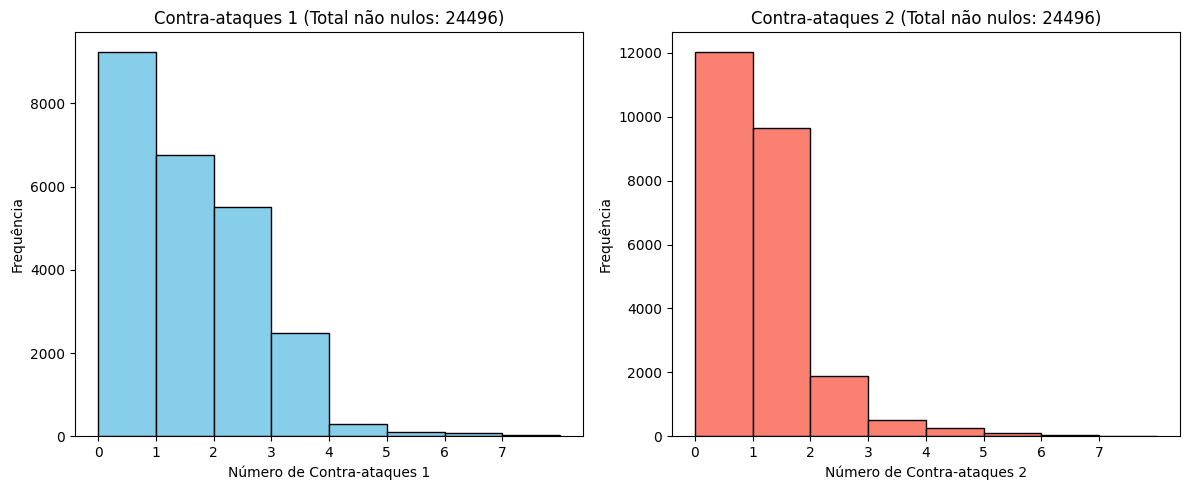

Tiro de meta 1 - média: 1.3079278249510125
Tiro de meta 2 - média: 0.8875530698889614
Tiro de meta 1 - mediana: 1.0
Tiro de meta 2 - mediana: 1.0


In [ ]:
def plotar_histogramas_duplos(caminho_csv, coluna1, coluna2):
    # Lê o dataset
    df = pd.read_csv(caminho_csv)

    # Extrai as colunas de interesse
    dados1 = df[coluna1]
    dados2 = df[coluna2]

    # Conta os valores não nulos
    count1 = dados1.notnull().sum()
    count2 = dados2.notnull().sum()

    # Cria os histogramas lado a lado
    plt.figure(figsize=(12, 5))

    # Histograma da primeira coluna
    plt.subplot(1, 2, 1)
    plt.hist(dados1.dropna(), bins=range(0, int(dados1.max()) + 2), edgecolor='black', color='skyblue')
    plt.title(f'{coluna1} (Total não nulos: {count1})')
    plt.xlabel(f"Número de {coluna1}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados1.max()) + 1))

    # Histograma da segunda coluna
    plt.subplot(1, 2, 2)
    plt.hist(dados2.dropna(), bins=range(0, int(dados2.max()) + 2), edgecolor='black', color='salmon')
    plt.title(f'{coluna2} (Total não nulos: {count2})')
    plt.xlabel(f"Número de {coluna2}")
    plt.ylabel('Frequência')
    plt.xticks(range(0, int(dados2.max()) + 1))

    plt.tight_layout()
    plt.show()

    print(f"Tiro de meta 1 - média: {dados1.mean()}")
    print(f"Tiro de meta 2 - média: {dados2.mean()}")
    print(f"Tiro de meta 1 - mediana: {dados1.median()}")
    print(f"Tiro de meta 2 - mediana: {dados2.median()}")

plotar_histogramas_duplos('saida_sem_outliers_preenchido.csv', 'Contra-ataques 1', 'Contra-ataques 2')

O comportamento do gráfico não mudou de forma brusca em relação ao original.